In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,116.860001,115.809998,115.919998,116.610001,22193600.0,111.727715
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.973305
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.008080
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.123047
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.736275


In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

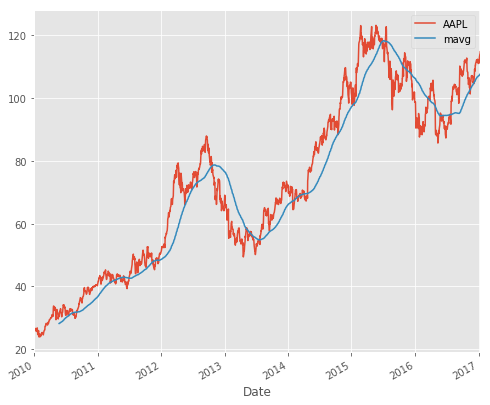

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()


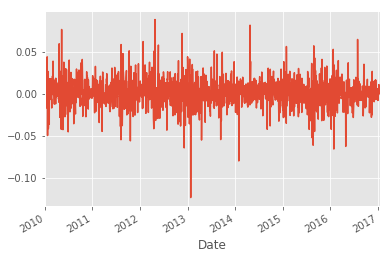

In [4]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [5]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [6]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [7]:
test_split = 200
X_train = X[:-test_split]
X_test = X[-test_split:]
y_train = y[:-test_split]
y_test = y[-test_split:]

In [8]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [9]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [10]:
print(f'confidence score for linear regression is {confidencereg}')
print(f'confidence score for 2nd degree polynomial regression  is {confidencepoly2}')
print(f'confidence score for 3rd degree polynomial regression  is {confidencepoly3}')
print(f'confidence score for KNN regression is {confidenceknn}')

confidence score for linear regression is 0.3017538568154773
confidence score for 2nd degree polynomial regression  is 0.3246944611143482
confidence score for 3rd degree polynomial regression  is 0.32695422213081693
confidence score for KNN regression is -0.0404917342997031


In [11]:
dfreg['KNN'] = clfknn.predict(np.concatenate((X_train,X_test, X_lately)))
dfreg['reg'] = clfreg.predict(np.concatenate((X_train,X_test, X_lately)))
dfreg['poly2'] = clfpoly2.predict(np.concatenate((X_train,X_test, X_lately)))
dfreg['poly3'] = clfpoly3.predict(np.concatenate((X_train,X_test, X_lately)))

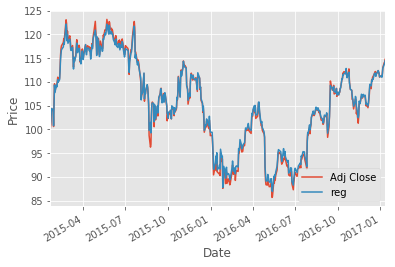

In [12]:
dfreg['Adj Close'].tail(500).plot()
dfreg['reg'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

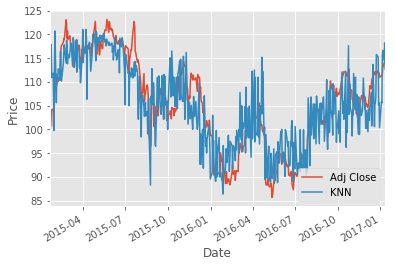

In [13]:
dfreg['Adj Close'].tail(500).plot()
dfreg['KNN'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

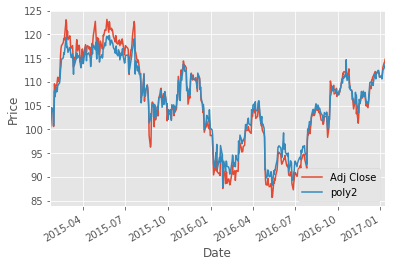

In [14]:
dfreg['Adj Close'].tail(500).plot()
dfreg['poly2'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

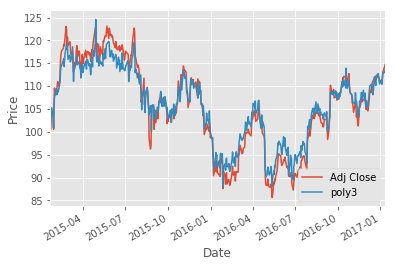

In [15]:
dfreg['Adj Close'].tail(500).plot()
dfreg['poly3'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()